# Neural Networks I
G. Richards
(2016, 2018, 2020, 2022)
[Ivezic 9.8](https://www.astroml.org/book_figures/chapter9/index.html) and [Geron](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_5?dchild=1&keywords=machine+learning&qid=1596499152&sr=8-5).   With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22).

I found this video series particularly helpful in trying to simplify the explanation https://www.youtube.com/watch?v=bxe2T-V8XRs. 


- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.
- Many blogs and videos.
- Free online book! http://neuralnetworksanddeeplearning.com/index.html

## Contents

Loss Functions, Gradient Descent, and AdaBoost are in Classification3.  Add them here??


* [Neural networks](#one)

Before we start today, we need to install some new software.  Go ahead and do this while you are waiting for lecture to start.

On the command line:
    
% python3 -m pip install --upgrade tensorflow

% pip install pydot

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
#import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1
Num CPUs Available:  1


In [4]:
from tensorflow import keras
print(keras.__version__)

2.10.0


Before lecture today, please go to https://playground.tensorflow.org/

Try the default. Note how the first layer identifies simple patterns and the second layer combines those to make more complex patterns. It also finds a solution quite quickly. (Note also that it won't stop on its own. Hit pause when you are happy with the solution it has converged on.)
Try a ReLU activation function. Much faster, but with a "boxy" solution.
See what happens when there is only 1 hidden layer with 3 neurons. Reset and run it multiple times.
Compare learning rate 0.001 to 1.0.
Now try just 2 neurons (with learning rate back at 0.3).
Now try 8 neurons.
Lastly try the spiral dataset with 4 hidden layers, each with 8 neurons. Run it for at least 1000-1500 epochs -- until it gets the answer "right" (make sure that your computer is plugged in and properly cooled!) This illustrates the vanishing gradient problem.
Do this again after lecture.
See Problem 10.1 in Geron

[Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network) are a simplified computation architecture based loosely on the real neural networks found in brains. 

![Neuron example](https://4.bp.blogspot.com/-Z5LfY6yoIcE/U-OFKWHoAbI/AAAAAAAAAKo/ytH6BzDLeo4/s1600/Picture-533.png)

In reality, what we are going to explore is a **[multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)**.

In the image below, 
- the circles on the ***left*** represent the **features/attributes** of our input data, $X$, which here is 3 dimensional.  
- the circles in the ***middle*** represent the **neurons**. They take in the information from the input and, based on some criterion decide whether or not to "fire". These middle layers are called "**hidden layers**".
- the collective results of the neurons in the hidden layer produce the **output**, $y$, which is represented by the circles on the ***right***, which here is 2 dimensional result.  
- the lines connecting the circles represent the synapses.  

This is a simple example with just one layer of neurons; however, there can be many layers of neurons.

![Cartoon of Neural Network](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/500px-Artificial_neural_network.svg.png)

Here are two graphics from an [article](https://towardsdatascience.com/artificial-intelligence-vs-machine-learning-vs-deep-learning-2210ba8cc4ac describing the relationship between artificial inteligence, machine learning and deep learning.

![MLvsDL1](https://miro.medium.com/max/1060/0*R53mzDRJXZ8l6idL)

![MLvsDL2](https://miro.medium.com/max/1400/0*2V2i5DbamWhswRV6)

Back to understanding this architecture.

![Cartoon of Neural Network](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/500px-Artificial_neural_network.svg.png)

The job of a synapse is to take input values and multiply them by some **weight**, $w$, and add a **bias**, $b$, before passing them to the neuron (hidden layer):

$$z = \sum_i w x_i + b$$

The bias determines the input level at which the neuron "fires". It is always present, and unique to each neuron, but we'll set that to zero for the sake of simplicity here.

The neuron then sums up the inputs from all of the synapses connected to it and applies an "**activation function**", e.g., a **[sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function**.

$$a = \frac{1}{1+e^{-z}}.$$

![Sigmoid Function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/500px-Logistic-curve.svg.png)

What the neural network does is to learn the weights of the synapses that are needed to produce an accurate model of $y_{\rm train}$.

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

Rather than think about the inputs individually, we can write this process in matrix form as
$$Z^{(2)} = X W^{(1)}$$

If $D$ is the number of attributes and $H$ is the number of neurons in the hidden layer, then $X$ is an $N\times D$ matrix, while $W^{(1)}$ is a $D\times H$ matrix.  The result, $Z^{(2)}$, is then an $N\times H$ matrix.

We then apply the activation function to each entry of $Z^{(2)}$ independently: 
$$A^{(2)} = f(Z^{(2)}),$$
where $A^{(2)}$ is the output of the neurons in the hidden layer and is also $N\times H$.

These values are then the inputs for the next set of synapses, where we multiply the inputs by another set of weights, $W^{(2)}:$
$$Z^{(3)} = A^{(2)} W^{(2)},$$

where $W^{(2)}$ is an $H\times O$ matrix and $Z^{(3)}$ is an $N\times O$ matrix with $O$-dimensional output.

Another activation function is then applied to $Z^{(3)}$ to give
$$\hat{y} = f(Z^{(3)}),$$
which is our estimator of $y$.

Following my previous examples, say we have $N=100$ skeletons for which we have measured 
* tibia length
* femur lenght
* ulna length

for which we know their species and gender.

Then we are going to use this to predict the species and gender of an unknown skeleton.

The neural network then essentially boils down to determining the weights of the synapses, which are usually initialized randomly.

We do that by minimizing the cost function (which compares the true values of $y$ to our predicted values).  Typically an MSE cost:
$$ {\rm Cost} = J = \sum\frac{1}{2}(y - \hat{y})^2.$$

Let's take a minute to talk about loss functions in detail.

As we saw above, that would be a cost function for regression (where we have only one output node).  For classification, we'd use one of the examples above (but ideally one that is differentiable as we'll see later).

### Loss Functions

**GTR: This part is updated in Classification3 for 2022.  If keeping it here, update here instead (or in addition).**

A [loss function](https://en.wikipedia.org/wiki/Loss_functions_for_classification) is like the cost functions that we discussed earlier, except for a single training example rather than the full data set.

Whether you realize it or not, you are typically working with $l2$ loss functions:
$$(y-f(x))^2,$$
where the corresponding cost function is the mean of those for all $x_i$ or the Mean Squared Error (MSE).

We also talked about $l1$ loss functions:
$$|y-f(x)|,$$
which is more robust to outliers.

For regression we plot loss vs. $y-f(x)$, where ideally we want that to be zero and would assign that zero "loss".

For classification we instead plot the loss vs. $y*f(x)$, where that is the known class (either $+1$ or $-1$) times the predicted value.  If that product is positive, we predict $+1$.  If it is negative, we predict $-1$.  

We define the loss to be zero for $y*f(x)=1$, that is, when we have gotten the right answer.

So what do the mean squared error (MSE or $l2$) and mean absolute error (MAE or $l1$) look like for classification?

In [5]:
# Mathematical formulas for various loss functions
def log_loss(raw_model_output):
   return np.log(1+np.exp(-raw_model_output))

def hinge_loss(raw_model_output):
   return np.maximum(0,1-raw_model_output)
 
def l2(raw_model_output):
   return (raw_model_output-1)**2  

def l1(raw_model_output):
   return np.abs(raw_model_output-1)  
 
def zero_one(raw_model_output):
   return np.where(raw_model_output < 0, 1, 0)   

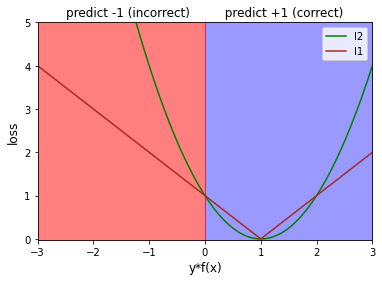

In [7]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
plt.plot(grid, l2(grid), color="g", label='l2')
plt.plot(grid, l1(grid), color="brown", label='l1')

plt.fill_between([0,3],-0.02,5, color="b",alpha=0.4)
plt.fill_between([-3,0],-0.02,5, color="r",alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-0.02,5])
plt.xlabel("y*f(x)",fontsize=12)
plt.ylabel("loss",fontsize=12)
plt.title("predict -1 (incorrect)         predict +1 (correct)",fontsize=12)
plt.legend()

plt.show()

Those would make sense if we plotted $y-f(x)$ as a value of $-1$ would be just as wrong as a value of $+1$.  

When plotting $y*f(x)\le1$ it kind of does something reasonable for $y*f(x)\le1$.  However, look what happens at larger values (where we are even more confident that $y*f(x)$ is positive and that our class should be $+1$.  The loss goes **up**.  That's bad.

Now, you may be wondering how $y*f(x)$ can be larger than 1.  Me too.  The internet is filled with useless non-answers.  But here's how this works.

$f(x)$ isn't just a value between $-1$ and $1$, it is a function.  For example, let's say that our training data looks like this:

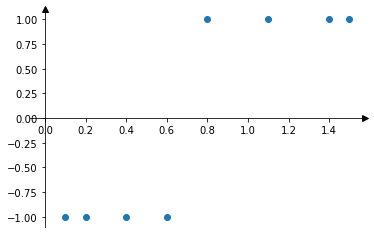

In [8]:
xx = np.array([0.1,0.2,0.4,0.6,0.8,1.1,1.4,1.5])
yy = np.array([-1,-1,-1,-1,1,1,1,1])

#with plt.xkcd():
if 1:
    
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('axes',0.045))
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
        
    ax.scatter(xx,yy)

Now let's fit a linear model to the training data:

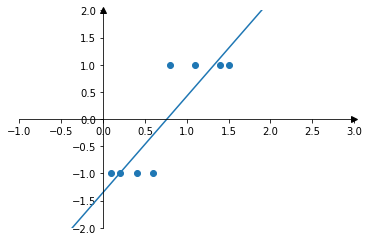

In [9]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(xx[:,None],yy)
ypred = linreg.predict(grid[:,None])

if 1:
    
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('axes',0.25))
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    
    ax.plot(grid,ypred)
    ax.set_xlim([-1,3])
    ax.set_ylim([-2,2])
        
    ax.scatter(xx,yy)

We see that for $x$ greater than about 1.3, $f(x)$ can indeed be larger than 1 and so can $y*f(x)$, which is indicating an increased certainty of the $+1$ class. 

OK, so now we can understand the plot, but we still need a loss function that makes sense for classification.

The first we'll try is the so-called ["Zero-One"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html) loss shown in **black**.  It is 1 for $yf(x)<0$ and 0 for $yf(x)>0$; thus the name.  You increment the loss function by 1 every time you make a wrong prediction.  It is just a count of the total number of mistakes.

However, the Zero-One loss is hard to minimize, so instead we can try something that allows the loss to be continuous function in $y*f(x)$.  

For example, the [Hinge Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html), which looks like
$${\rm max}(0,1-y*f(x)),$$
as plotted in **orange**.  Here there is no contribution to the loss for values $\ge 1$, but there is an linearly increasing loss for smaller values.  So, it penalizes both wrong predictions and also correct predictions that have low confidence.

A [logistic loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss) (also called the log loss and cross entropy loss) function has similar properties as shown in **blue**, but is smoother and has slightly less and less penalty for more and more confident $+1$ predictions.

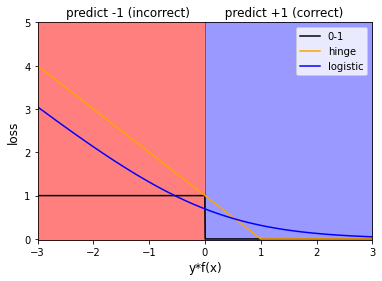

In [11]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, zero_one(grid), "k", label='0-1')
plt.plot(grid, hinge_loss(grid), "orange", label='hinge')
plt.plot(grid, log_loss(grid), "b", label='logistic')
#plt.plot(grid, l2(grid), label='l2')
#plt.plot(grid, l1(grid), label='l1')

plt.fill_between([0,3],-0.02,5,color="b",alpha=0.4)
plt.fill_between([-3,0],-0.02,5,color="r",alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-0.02,5])
plt.xlabel("y*f(x)",fontsize=12)
plt.ylabel("loss",fontsize=12)
plt.title("predict -1 (incorrect)         predict +1 (correct)",fontsize=12)
plt.legend()

plt.show()

For more see [Linear Classsifiers in Python course](https://learn.datacamp.com/courses/linear-classifiers-in-python).  Also

https://datascience103579984.wordpress.com/2019/09/18/linear-classifiers-in-python-from-datacamp/

https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23

https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code

http://www.datasciencecourse.org/notes/linear_classification/

OK, back to trying to minimize the loss function by tweaking the weights connecting each neuron.

If we just had 1 weight and we wanted to check 1000 possible values, that wouldn't be so bad.  But if we have 20 weights, that means checking $20^{1000}$ possible combinations.    Remember the curse of dimensionality?  That might take a while.  Indeed, far, far longer than the age of the Universe.

### Backpropagation

However some clever techniques have evolved out of realizing that we can write an analytic formula for the *gradient* going backwards through the network, and use that to update our weights (and biases, of course).

For example, how about just checking 3 points for each weight and see if we can at least figure out which way is "down hill"? That's a start.

We can rewrite $J$ as
$$ J = \sum\frac{1}{2}\left(y - f\left( f(X W^{(1)}) W^{(2)} \right) \right)^2$$

and then compute
$$\frac{\partial J}{\partial W}$$
in order to determine the slope of the cost function for each weight.  This is the **gradient descent** method.  Your choice of cost function is important here; specifically you want it to be differentiable.

**GTR: From Vanderbilt**

We'll want $\partial J/\partial W^{(1)}$ and $\partial J/\partial W^{(2)}$ separately. This allows us to ***[backpropagate](https://en.wikipedia.org/wiki/Backpropagation)*** the error contributions along each neuron and to change the weights where they most need to be changed.  It is like each observation gets a vote on which way is "down hill".  We compute the vector sum to decide the ultimate down hill direction.

Once we know the down hill direction from the derivative, we update the weights by subtracting a scalar (the *learning rate*) times that derivative from the original weights-- this is just gradient descent! This is obviously much faster than randomly sampling all the possible combinations of weights.  

<font color='red'>Watch the following short video to understand more of the mathematics of **backpropagation (= "backward propagation of errors")**.</font>

### Gradient Descent

**GTR: This is updated in Classification3 for 2022.  Merge in here if desired.**

That brings us to the topic of [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) which comes in for log loss because there is no analytic solution (can't write the equation for $\theta$ as we have been).

Throughout the couse we have been trying to determine model parameters, $\theta$, that minimize either the regression error or the classification error when fitting our training data (and not overfitting!). 

Sometimes we have been able to write an analytic solution for $\theta$.  In MCMC we semi-randomly sampled the multi-dimensional $\theta$ space to find the best answer (and map the full parameter space along the way).  But what happens if you are stuck on top of a freezing cold mountain and you have no map and can't magically jump from place to place?  You start walking **down**.  That's the basic idea of gradient descent--take a look around you, figure out which way is sloping downward the most and go *that* way.

We are going to determine the local gradient of the loss function with respect to $\theta$ and go in the steepest direction, until the gradient is zero (and we have arrived at our destination).

Mathematically, we have 

$$\nabla_{\theta}{\rm MSE}({\mathbf \theta}) = \frac{2}{N}X^T(X\theta - y)$$

That gives the uphill direction, so we compute the next step as

$$\theta^{\rm next step} = \theta - \eta\nabla_{\theta}{\rm MSE}({\mathbf \theta}),$$

where $\eta$ is the "learning rate" and the rest are all matrices or vectors.

Note that the initial values for $\theta$ are chosen randomly.


We'll want $\partial J/\partial W^{(1)}$ and $\partial J/\partial W^{(2)}$ separately.  This allows us to [*backpropagate*](https://en.wikipedia.org/wiki/Backpropagation) the error contributions along each neuron and to change the weights where they most need to be changed.  It is like each observation gets a vote on which way is "down hill".  We compute the vector sum to decide the ultimate down hill direction.

Once we know the down hill direction from the derivative, we update the weights by subtracting a scalar times that derivative from the original weights.  That's obviously much faster than randomly sampling all the possible combinations of weights.  Once the weights are set, then you have your Neural Network classifier/regressor.

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

#### Learning Rates

The [learning rate](https://en.wikipedia.org/wiki/Learning_rate), which controls how big your steps "down" are.  If your step size is too small, it will take too long to converge.  If it is too big, you might miss the bottom completely (and possibly end up diverging from the solution).  


![https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png](https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png)

We also have to be careful that we don't end up in a local minimum instead of the global minimum.  (One of the nice things about the $l2$ cost function is that it is guaranteed to have just a single global minimum.

Diverges because the sign of the gradient was opposite to what it just was?  Add figure showing this?

Note that gradient descent is also useful for regression where too many training points (or too many features) to fit into memory.

Here's an example from Geron where we apply gradient descent to a simple linear regression problem.

In [12]:
#Run the next 4 cells
#N points randomly drawn from a linear distribution
N=100
X = 2 * np.random.rand(N, 1)
y = 4 + 3 * X + np.random.randn(N, 1)

#Turn X into a matrix
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each 

#Grid for plotting
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance

X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

In [13]:
eta = 0.1  # learning rate
n_iterations = 100
theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/N * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
n_lines=10
color_idx = np.linspace(0, 1, n_lines)
#Helper function
theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            #style = "b-" if iteration > 0 else "r--"
            #plt.plot(X_new, y_predict, style)
            plt.plot(X_new, y_predict, color=plt.cm.cool(color_idx[iteration]))
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

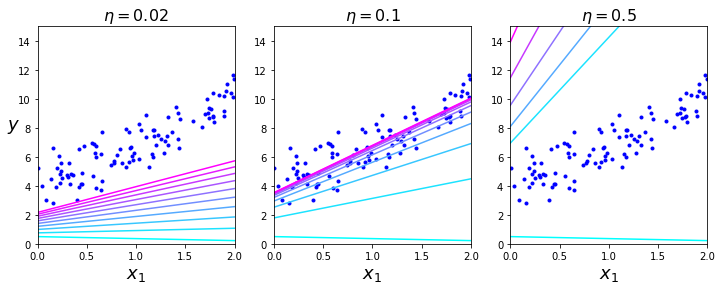

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(12,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

On the left our learning rate is too low; we'll eventually get to the solution, but it will take a long time.  On the right it is too high and we have completely missed the solution.  In the middle is just right.

Try $\eta = 0.3$ and $0.4$ to see if you can understand what is going on in the right panel.

So, getting the learning rate right is important both for converging quickly and even doing so at all.

[Geron11-8.png](attachment:Geron11-8.png)

You also don't have to keep the learning rate fixed, but can instead do learning rate scheduling.  For example, see this [article](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c).

[Geron](../figures/Geron11-8.png)

Scikit-Learn has both [unsupervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html#neural-networks-unsupervised) and [supervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised) examples. 

Let's try to use the multi-layer perceptron classifier on the California House Price dataset (using 75% of the data for training and 25% for testing).

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

X = housing.data
y = housing.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(Xtrain)
Xtest_scaled = preprocessing.scale(Xtest)
Xscaled = preprocessing.scale(X)

[(8, 5), (5, 2), (2, 1)]


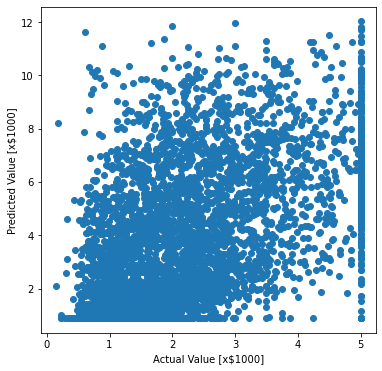

In [17]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1, max_iter=5000)
clf.fit(Xtrain_scaled, ytrain)

# Look at the weights
print([coef.shape for coef in clf.coefs_])

ypred = clf.predict(Xtest_scaled)
#print ypred, ytest

fig = plt.figure(figsize=(6, 6))
plt.scatter(ytest,ypred)
plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

Of course, that only predicts the value for a fraction of the data set. <font color='red'>Again, we can use Scikit-Learn's [cross_val_predict](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) to make predictions for the full data set.</font>

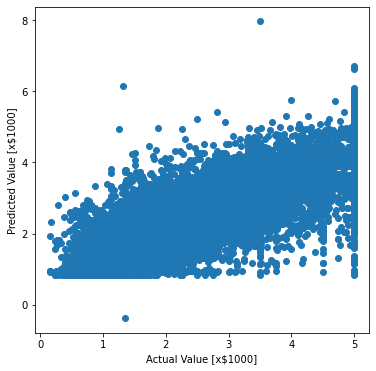

In [18]:
from sklearn.model_selection import cross_val_predict

yCVpred = cross_val_predict(clf, Xscaled, y, cv=5) # Complete

fig = plt.figure(figsize=(6, 6))
plt.scatter(y,yCVpred)
plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

Just as with other model hyperparameters, we can use cross-validation to determine the optimal number of layers, neurons per layer, etc. But for now, let's talk about some guidelines.

### Number of Layers

Ivezic: 

> "*For data that can be represented by a linear model, no layers are required (McCullagh & Nelder 1989).  A single layer network can approximate any continuous function.  Two layers can represent arbitrary decision boundaries for smooth functions (Lippmann 1987).  More layers can represent non-continuous or complex structure within the data.*"  

Think about why no layers are needed for linear regression.  We just connect our input to the output where the synapses are the weights (slopes) and the output neurons add the constant (intecept).

So you might start with a single layer, then add more layers and use cross-validation to determine when you are overfitting.

Geron has a good example of what adding layers does.  Say you had to draw a whole forest, but you couldn't cut and paste anything.  That would be very tedious.  But if you could draw just one leaf and copy that to make a small branch, then scale up a small branch to a big branch and copy that, then attach the branches to a tree trunk and then make copies of the full tree, you wouldn't have to draw all that much.  **Each of the layers in a neural network handles  more and more detailed aspects of the problem.**

For image recognition, you might need dozens of layers, but also a huge training set to populate those layers.

### Number of Neurons

The number of neurons in each layer is also a free parameter. 

- ***Typically choose somewhere between twice the number of input nodes and a number between the number of input and output nodes.***


- If there are lots hidden layers (where "lots" is not clearly defined) then we call that a **deep neural network or [deep learning](https://en.wikipedia.org/wiki/Deep_learning)**. 


- Sometimes the number of neurons in each layer goes down.  But it can also be useful to have the same number in each layer so that there is only one hyperparameter (the number of neurons) and not one per layer.


- In practice a reasonable approach is to simply **specify many more layers and neurons than you need and perform regularization**. This can be as simple as just stopping the training when the cross-validation error reaches a minimum, which appropriately (for once) is called **[early stopping](https://en.wikipedia.org/wiki/Early_stopping)**. Basically, you put your `fit` method into a loop and instantiate with `max_iter=1` and `warm_start=True`.  See Geron (page 141) for an example.


While the number of neurons in the hidden layers are free parameters the number of input and output nodes are constrained by the data and the desired output.  For example, the MNIST digits data requires 784 input neurons (one for each pixel in the 28x28 images) and 10 output neurons (one for each class [digit]).  

### Activation Functions

The **[Activation function](https://en.wikipedia.org/wiki/Activation_function)** controls how much "signal" it takes for a neuron to "fire".  The more signal, the more likely the neuron will fire. See https://mlfromscratch.com/activation-functions-explained/#/

The cells below show different activation functions, using the same visualization as we used for loss functions.

In [19]:
# Mathematical formulas for activation functions
  
def binary(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    1)  

def sigmoid(raw_model_output):
    return 1.0 / (1 + np.exp(-raw_model_output))

def ReLU(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    raw_model_output)

def LReLU(raw_model_output):
    alpha=0.1
    return np.where(raw_model_output < 0, 
                    alpha*raw_model_output, 
                    raw_model_output)

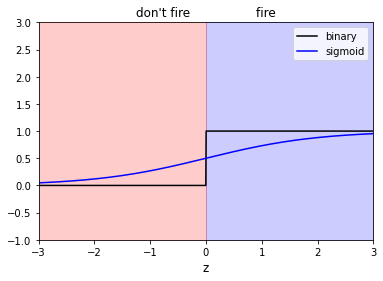

In [20]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, binary(grid), "k", label='binary')
plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
#plt.plot(grid, ReLU(grid), label='ReLU')
#plt.plot(grid, LReLU(grid), label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                 fire",fontsize=12)
plt.legend()

plt.show()

"*On vs. Off*" activation actually isn't quite true or what we want. The way your eyes work is that you need 1-10 photons to trigger a rod, but several rods must be triggered to send a signal to the brain. The sigmoid activation function captures the probabilistic nature of neuron firing. More importantly it is differentiable, so can be used for backpropagation.

Another important aspect of non-linear activation functions is that they are what allow neural networks to solve non-linear problems.  If we used a strictly linear activation function, then we could only solve linear problems.  That is, you could fit a straight line, but not an exponential.

If you wanted to make the activation function a parameter, here's how to find out what your options are

In [21]:
#Different activation functions that are available
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

#### Vanishing and Exploding Gradients

Neural network research suffered significant limitations and problems at the hands of the [vanishing and exploding gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  We won't go into detail there except to say that ***around 2010 there were suggestions for different activation functions that were published.***  

- For example, the **[Rectified Linear Unit (ReLU) activation function](https://www.wikiwand.com/en/Rectifier_(neural_networks))** is another commonly used activation function as it solves the vanishing gradient problem (since the gradient is only 0 or 1).
$${\rm ReLU}(z) = max(0,z)$$


- It isn't ideal both because the derivative is 0 for $z<0$ and it can end up producing dead nodes. However, it is fast and the resulting sparsity can be good (sort of like regularization).


- A number of papers since 2015 describe various improvements, including the **Leaky ReLU**, the **exponential linear unit (ELU)**, and **scaled exponential linear unit (SELU)**.


Note that the activation functions can be different in different layers.  For example, for regression, one typically doesn't use any activation function in the output layer as including one would restrict the range of possible outputs

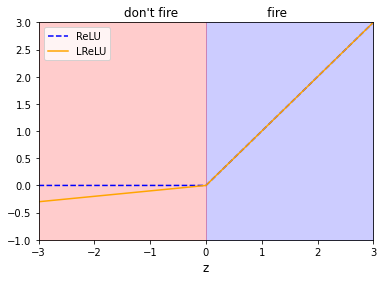

In [22]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
#plt.plot(grid, binary(grid), "k", label='binary')
#plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
plt.plot(grid, ReLU(grid), "b--", label='ReLU')
plt.plot(grid, LReLU(grid), "orange", label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                       fire",fontsize=12)
plt.legend()

plt.show()

Some general guidance on activation functions:
    
* **Use sigmoid for output of binary classification (with binary cross entropy loss)**


* **Use ReLU for layers other than output (at least to start with because it is faster)**


* **Use softmax for output with more than 2 classes (with categorical cross entropy loss)**

### Regularization

Just as we can use regularization for standard regression and classification tasks, so too can we with neural networks.  

Not only can we apply the usual $L1$ (LASSO) or $L2$ (Ridge) regularization techniques, we can also use **dropout** which, as the name indicates, causes some neurons to be temporarily "dropped out" during training (usually by setting some probability for that to happen, typically 10-50%). After training, all of the neurons are used.

*Geron* explains this in terms of a company needing to try to figure out how to adapt to a crucial employee being out sick for a period of time.  In the end, it can make the company stronger as more people (neurons) are able to handle certain parts of the process.

One form of regularization is  "early stopping".  This will determine when there hasn't been any improvement in the validation set for `patience` epochs and stop the fitting.  It also uses the "best" weights and just the "last" weights.

### Batch normalization

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called **[batch normalization](https://en.wikipedia.org/wiki/Batch_normalization)** and is done before passing the data to the activation function.  It make the process more stable and can also make it faster.  We'll do an example next time. 

### Faster Optimizers

We aren't going to talk about optimizers, but it might be useful for you to have some options to feed into a search for the best parameter using cross validation.  For example **`['mse', 'adam', 'sgd', 'adagrad']`**.

---

**GTR: Stop the notebook here and start another?  But leaving this for now.**

If we want to do anything more complicated, we'll need to use something other than Scikit-Learn.  Enter Keras and TensorFlow.

[Keras](https://keras.io/) is a deep learning API.  Essentially it is Scikit-Learn for deep neural networks.

Keras needs a computational backend to handle the heavy computation.  Three popular (open sources) deep learning libraries are [TensorFlow](https://www.tensorflow.org/), Microsoft Cognitive Toolkit, and [Theano](http://www.deeplearning.net/software/theano/).  TensorFlow now comes bundled with a version of Keras and that's what we'll use here (actually TensorFlow 2).  Another option is PyTorch.   Section 9.8 of Ivezic includes examples using both `keras` and `torch`.

If you apply for a data-science job in industry knowing one of these tools might be the most useful thing for you to have learned.

In short, for neural networks:

> numpy -> tensorflow

> sklearn -> keras

In the same way that you can build a linear regression algorithm in numpy without using sklearn, you can build a neural network algorithm (not to mention linear regression) in tensorflow without using keras.  But just as sklearn makes our life easier, so too does keras.  Keras has Sequential and Functional APIs.  We will just use Sequential in our examples.

Just as I'm teaching you about sklearn and not numpy, I have no intention of teaching you tensorflow, so this notebook should really be named keras.ipynb and not tensorflow.ipynb.  

The following cells are from Geron, Chapter 10, see 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

I'll indicate below when I switch chapters.

We'll start by introducing the Fashion MNIST data set, which is as common for learning about neural networks as the MNIST are for machine learning in general.  We can also use the MNIST data too.

The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [23]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [24]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


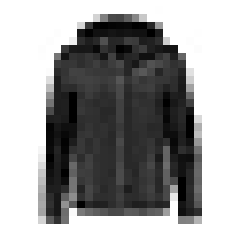

In [25]:
plt.imshow(X_train[0], cmap="binary", origin='upper') #Origin controls right-side up
plt.axis('off')
plt.show()

Take a look at some of the other entries in the training data.  Also see what happens when you remove the `origin='upper'` parameter.

In [26]:
#Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

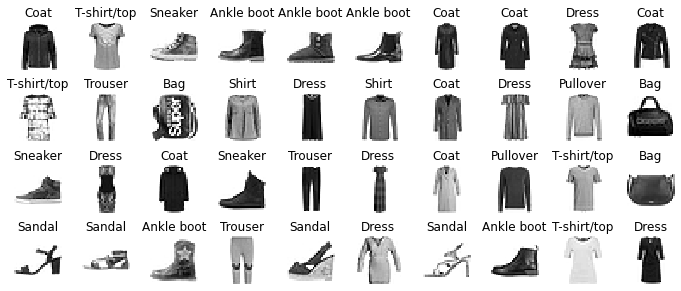

In [27]:
# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now we'll build a "simple" neural network that classifies an unknown image (preprocessed to have the same image and color scale) into one of these 10 categories.

In [28]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential() #Instantiate a sequential model
model.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model.add(keras.layers.Dense(10, activation="softmax")) #Output layer

Metal device set to: Apple M1 Pro


2022-11-15 20:55:16.307507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 20:55:16.308402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[GTR: this notebook currently doesn't discuss activation functions until later.  Might need to fix that.]

Need to define the input size/shape for the first layer.  The others know how to talk to each other.  The last layer sets the number of outputs.  Need softmax here because there are 10 categories.  If just one output or two, then a different activation function would be used.

In [30]:
#Let's see what we just built
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The number of parameters in each layer is one for each weight that connects each node of the layer to the previous layer, plus the number of neurons in the layer to account for the constant "bias" parameter (e.g., 784x300+300 = 235500).

Note that "Dense" here means "fully connected".  That is, each node in one layer is connected to each node in the next layer.  This does't always have to be the case.  The layers can instead be "Sparse".

We can access (or set) the weights with `get_weights()` and `set_weights()` as follows.  Note that the initial weights are set randomly and the bias values are initially zero.

In [31]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
#Weights set to random numbers to break degeneracy
#Biases are set to 0
print(weights.shape,weights,biases)

(784, 300) [[-0.03435203  0.07306209  0.05982348 ...  0.05257651  0.058393
   0.01872874]
 [ 0.01666184 -0.03675376  0.07421866 ... -0.05267569  0.02351782
   0.04638566]
 [-0.07437211  0.0241164   0.06424564 ... -0.03721029 -0.04889008
  -0.00324023]
 ...
 [ 0.04940728  0.05726938 -0.06743476 ... -0.05093856 -0.00513876
  -0.04111585]
 [ 0.00293155 -0.07112566  0.01772861 ... -0.05935838  0.01317304
  -0.02696794]
 [ 0.07284217  0.00789727 -0.02834688 ... -0.03078052  0.01495388
  -0.01438194]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

For neural networks we can't just fit the model after we instantiate it.  We need to compile first--specifying the loss function, the optimizer, and any desired metrics.

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Now we can go ahead and fit the model with our training data.  The fit method will output a bunch of useful diagnostics that we'll save to `history` for plotting later.

In [33]:
history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_valid, y_valid))

Epoch 1/25


2022-11-15 20:55:55.856971: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 20:55:56.063429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7606

2022-11-15 20:56:07.680733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 13s 6ms/step - loss: 0.7260 - accuracy: 0.7606 - val_loss: 0.5219 - val_accuracy: 0.8212
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4909 - accuracy: 0.8282 - val_loss: 0.4413 - val_accuracy: 0.8506
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4458 - accuracy: 0.8436 - val_loss: 0.5438 - val_accuracy: 0.7954
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4194 - accuracy: 0.8539 - val_loss: 0.3995 - val_accuracy: 0.8642
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4010 - accuracy: 0.8606 - val_loss: 0.3854 - val_accuracy: 0.8648
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3822 - accuracy: 0.8651 - val_loss: 0.3772 - val_accuracy: 0.8700
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3695 - accuracy: 0.8693 - val_loss: 0.3714 - val_accuracy: 0.8

Comment on what is happening with loss, val_loss, and accuracy.

Our metrics of interest were printed at each epoch (each pass through the neural network to update the weights), but it is easier to just look at a plot!

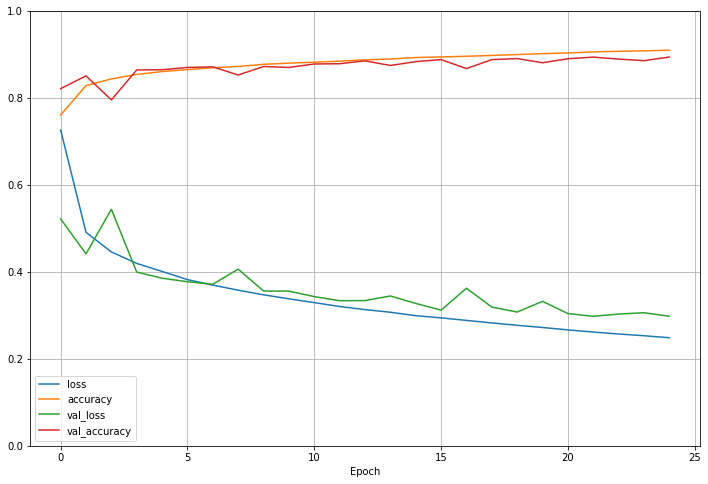

In [34]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

As was the case for model training before, we want to make sure that we aren't overtraining, which would be indicated by the training loss diverging from the validation loss.  Note that, instead of creating a specific validation set, we can also pass `validation_split=0.1` as a parameter during the fitting step to split off 10% of the data for validation.

Now we will `evaluate` the model using the test set to determine the expected level of error on unknown data.    The usual `predict` method then can be used to make predictions.  [GTR: I'm not sure the reason for this structure.  In regular ML we would `predict` on the test set and the compute metrics with the output values.]

In [35]:
#Evaluate the test set
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3327 - accuracy: 0.8847


[0.3326593041419983, 0.8847000598907471]

In [36]:
#Predict values for first 3 test objects
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

1/1 [==============================] - 0s 160ms/step
[[0.   0.   0.   0.   0.   0.02 0.   0.01 0.   0.97]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


2022-11-15 21:01:53.364859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [37]:
#y_pred = model.predict_classes(X_new) #Old way
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

1/1 [==============================] - 0s 13ms/step
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


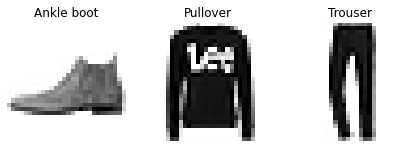

In [38]:
#Let's plot those and see if the predictions make sense.
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [39]:
#Save model
model.save("my_keras_model.h5")

#Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects.  Display them with their actual labels first, then predict and display the predictions.

In [40]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
#y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1)

1/1 [==============================] - 0s 142ms/step


2022-11-15 21:02:11.595728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


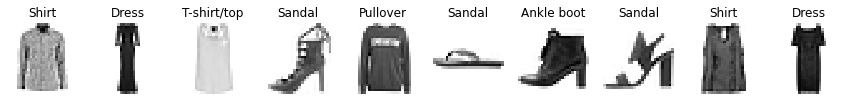

In [41]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

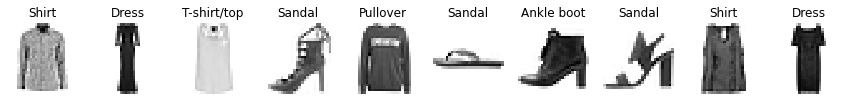

In [42]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

---

Here's a regression example instead of classification

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)

(11610, 8)
(11610,)


In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 21:03:56.095451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - ETA: 0s - loss: 2.9387

2022-11-15 21:03:58.289708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 3s 5ms/step - loss: 2.9387 - val_loss: 1.2561
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.9369 - val_loss: 1.0182
Epoch 3/20
363/363 [==============================] - 2s 4ms/step - loss: 0.7700 - val_loss: 0.8218
Epoch 4/20
363/363 [==============================] - 2s 4ms/step - loss: 0.7108 - val_loss: 0.6630
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6699 - val_loss: 0.6254
Epoch 6/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6345 - val_loss: 0.6662
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6060 - val_loss: 0.7325
Epoch 8/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5821 - val_loss: 0.5522
Epoch 9/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5571 - val_loss: 0.5961
Epoch 10/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5374 - val_loss: 0.6455
Epoch 11/2

2022-11-15 21:04:29.622184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Activation Functions

[Activation function](https://en.wikipedia.org/wiki/Activation_function) control how much "signal" it takes for a neuron to "fire".  The more signal, the more likely the neuron will fire.

See
https://mlfromscratch.com/activation-functions-explained/#/

The cells below show different activation functions, using the same visualization as we used for loss functions.  It is important to understand the differences between them and when you can and cannot use certain activation functions.  For example, the activation function of your output layer depends on your output (specifically regression, binary classification, or multi-class classification).

In [45]:
# Mathematical formulas for activation functions

def binary(raw_model_output):
   return np.where(raw_model_output < 0, 0, 1)  

def sigmoid(raw_model_output):
   return 1.0/(1+np.exp(-raw_model_output))

def ReLU(raw_model_output):
   return np.where(raw_model_output < 0, 0, raw_model_output)

def LReLU(raw_model_output):
   alpha=0.1
   return np.where(raw_model_output < 0, alpha*raw_model_output, raw_model_output)

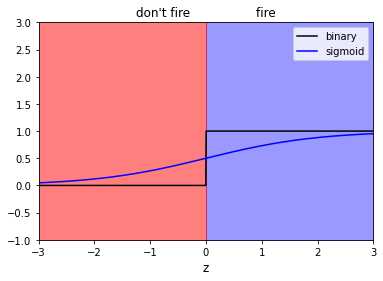

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, binary(grid), "k", label='binary')
plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
#plt.plot(grid, ReLU(grid), label='ReLU')
#plt.plot(grid, LReLU(grid), label='LReLU')
#plt.plot(grid, l2(grid), label='l2')
#plt.plot(grid, l1(grid), label='l1')

plt.fill_between([0,3],-1,3,color="b",alpha=0.4)
plt.fill_between([-3,0],-1,3,color="r",alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
#plt.ylabel("probability",fontsize=12)
plt.title("don't fire                 fire",fontsize=12)
plt.legend()

plt.show()

Until the paper describing backpropagation, a step (binary) function was used for activation: that is either *on* or *off*, which makes sense as neurons either fire or they don't.  However, the step function doesn't have gradients, so backpropagation won't work with them.  

Moreover on vs. off actually isn't quite true.  The way your eyes work is that you need 1-10 photons to trigger a rod, but several rods must be triggered to send a signal to the brain.  The sigmoid activation function captures the probabilistic nature of neuron firing.  More importantly it is differentiable, so can be used for backpropagation.

Another important aspect of non-linear activation function is that they are what allow neural networks to solve non-linear problems.  If we used a strictly linear activation function, then we could only solve linear problems.  That is, you could fit a straight line, but not an exponential.

#### Vanishing and Exploding Gradients

However, neural networks suffered their 2nd death at the hands of the [vanishing and exploding gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  We won't go into detail there except to say that life #3 began around 2010 when suggestions for different activation functions were published.  

For example, the Rectified Linear Unit (ReLU) activation function is another commonly used activation function as it solves the vanishing gradient problem (since the gradient is only 0 or 1).

$${\rm ReLU}(z) = max(0,z)$$

It isn't ideal both because the derivative is 0 for $z<0$ and it can end up producing dead nodes.  However, it is fast and the resulting sparsity can be good (sort of like regularization).

A number of papers since 2015 describe various improvements, including the Leaky RELU, the exponential linear unit (ELU) and scaled exponential linear unit (SELU).

Note that the activation functions can be different in different layers.  For example, for regression, one typically doesn't use any activation function in the output layer as including one would restriction the range of possible outputs.

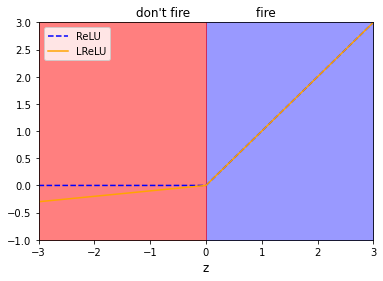

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
#plt.plot(grid, binary(grid), "k", label='binary')
#plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
plt.plot(grid, ReLU(grid), "b--", label='ReLU')
plt.plot(grid, LReLU(grid), "orange", label='LReLU')
#plt.plot(grid, l2(grid), label='l2')
#plt.plot(grid, l1(grid), label='l1')

plt.fill_between([0,3],-1,3,color="b",alpha=0.4)
plt.fill_between([-3,0],-1,3,color="r",alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
#plt.ylabel("probability",fontsize=12)
plt.title("don't fire                 fire",fontsize=12)
plt.legend()

plt.show()

Some general guidance on activation functions (more on this later):
    
* Use sigmoid for output of binary classification (with binary cross entropy loss)
* Use ReLU for layers other than output (at least to start with because it is faster)
* Use softmax for output with more than 2 classes (with categorical cross entropy loss)

If you wanted to make the activation function a parameter, here's how to find out what your options are

In [50]:
#Different activation functions that are available
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

---

### Regularization

Just as we can use regularization for standard regression and classification task, so too can we with neural networks.  

Not only can we apply the usual $l1$ or $l2$ regularization techniques, but we can also use *dropout* which, as the name indicates, causes some neurons to be temporarily "dropped out" during training (usually by setting some probability for that to happen, typically 10-50%).  After training, all of the neurons are used.

Geron explains this as a company needing to try to figure out how to adapt to a crucial employee being out sick for a period of time.  In the end, it can make the company stronger as more people (neurons) are able to handle certain parts of the process.

We'll do an example of this next time.

One form of regularization is  "early stopping".  This will determine when there hasn't been any improvement in the validation set for `patience` epochs and stop the fitting.  It also uses the "best" weights and just the "last" weights.

In [51]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4387 - val_loss: 0.4142
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4353 - val_loss: 0.4062
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4322 - val_loss: 0.4020
Epoch 4/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4289 - val_loss: 0.4017
Epoch 5/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4267 - val_loss: 0.4002
Epoch 6/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4239 - val_loss: 0.4000
Epoch 7/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4219 - val_loss: 0.3946
Epoch 8/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4196 - val_loss: 0.3952
Epoch 9/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4175 - val_loss: 0.3890
Epoch 10/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4156 - val_lo

363/363 [==============================] - 1s 4ms/step - loss: 0.3649 - val_loss: 0.3461
Epoch 82/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3646 - val_loss: 0.3578
Epoch 83/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3643 - val_loss: 0.3442
Epoch 84/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3639 - val_loss: 0.3453
Epoch 85/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3638 - val_loss: 0.3433
Epoch 86/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3635 - val_loss: 0.3710
Epoch 87/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3632 - val_loss: 0.3435
Epoch 88/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3628 - val_loss: 0.3436
Epoch 89/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3626 - val_loss: 0.3454
Epoch 90/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3625 - val_loss: 

Note that we told it that it could run for as many as 100 epochs if it wanted to, but it stopped after 74.

Now we can plot the results.

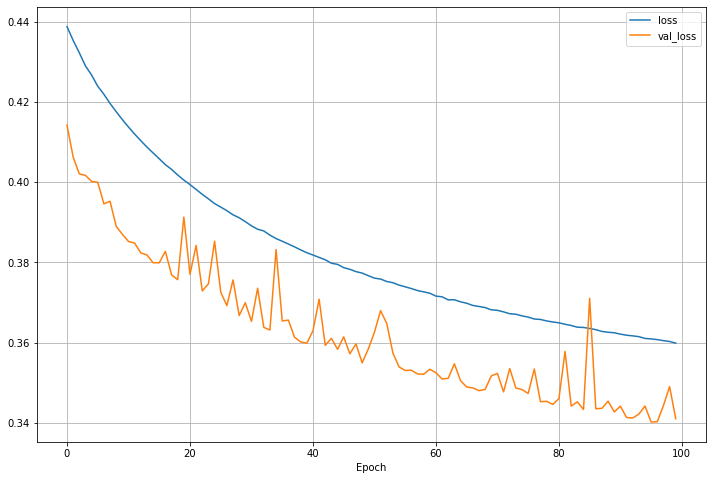

In [52]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

Here's an example of how to do regularization with [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)).

![DropoutDiagram](https://miro.medium.com/max/1400/1*tvcv2PT3cBAmUtZzQTmjeQ.png)

In [53]:
#Back to the fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [54]:
#Dropout example
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #20% chance of neuron stuck in off position
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2


2022-11-15 21:10:45.763264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.8021

2022-11-15 21:11:08.057229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 24s 13ms/step - loss: 0.5454 - accuracy: 0.8021 - val_loss: 0.4133 - val_accuracy: 0.8508
Epoch 2/2
1719/1719 [==============================] - 22s 13ms/step - loss: 0.4178 - accuracy: 0.8467 - val_loss: 0.3548 - val_accuracy: 0.8694


---

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) and is done before passing the data to the activation function.  It make the process more stable and can also make it faster. 

Here's an example using batch normalization.

[GTR: Not sure where to put this.]

In [55]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_8 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In some cases you might want to do the batch normalization before applying the activation function.  Here we also turn off the bias parameter because it ends up not being needed and just wastes a parameter.

In [57]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [59]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [60]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


2022-11-15 21:11:59.523168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.6795

2022-11-15 21:12:14.735481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 16s 9ms/step - loss: 1.0529 - accuracy: 0.6795 - val_loss: 0.6736 - val_accuracy: 0.7918
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6705 - accuracy: 0.7874 - val_loss: 0.5523 - val_accuracy: 0.8228
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5868 - accuracy: 0.8080 - val_loss: 0.4991 - val_accuracy: 0.8348
Epoch 4/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.5370 - accuracy: 0.8220 - val_loss: 0.4676 - val_accuracy: 0.8438
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5058 - accuracy: 0.8301 - val_loss: 0.4454 - val_accuracy: 0.8520
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4848 - accuracy: 0.8345 - val_loss: 0.4283 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4685 - accuracy: 0.8401 - val_loss: 0.4159 - val_accuracy: 0.8

---

We have a number of hyperparameters that can be tuned when building the architecture of our neural network (such as the number of hidden layers and the number of neurons in those layers).  But also the activation functions, learning rates, etc.

Just as with other model hyperparameters, we can use cross-validation to determine the optimal number of layers, neurons per layer, etc.  We'll do that in detail later.  For now, let's talk about some guidelines.

### Number of Layers

Ivezic: 
> "For data that can be represented by a linear model, no layers are required (McCullagh & Nelder 1989).  A single layer network can approximate any continuous function.  Two layers can represent arbitrary decision boundaries for smooth functions (Lippmann 1987).  More layers can represent non-continuous or complex structure within the data."  


Think about why no layers are needed for linear regression.  We just connect our input to output where they synapses are the weights (slopes) and the output neurons add the constant (intecept).

So you might start with a single layer, then add more layers and use cross-validation to determine when you are overfitting.

Geron has a good example of what adding layers does.  Say you had to draw a whole forest, but you couldn't cut and paste anything.  That would be very tedious.  But if you could draw just one leaf and copy that to make a small branch, then scale up a small branch to a big branch and copy that, then attach the branches to a tree trunk and then make copies of the full tree, you wouldn't have to draw all that much.  Each of the layers in a neural network handles  more and more detailed aspects of the problem.  We saw this in the opening pre-lecture experiments.

For image recognition, you might need dozens of layers, but also a huge training set to populate those layers.

### Number of Neurons

The number of neurons in each layer is also a free parameter.  Typically choose somewhere between twice the number of input nodes and a number between the number of input and output nodes.

If there are lots of hidden layers (where "lots" is not clearly defined) then we call that a deep neural network or [deep learning](https://en.wikipedia.org/wiki/Deep_learning).  More on that later.


Sometimes the number of neurons in each layer goes down.  But it can also be useful to have the same number in each layer so that there is only one hyperparameter (the number of neurons) and not one per layer.

In practice a reasonable approach is to simply specify many more layers and neurons than you need and perform regularization.  This can be as simple as just stopping the training when the cross-validation error reaches a minimum, which appropriately (for once) is called [early stopping](https://en.wikipedia.org/wiki/Early_stopping).  Basically, you put your `fit` method into a loop and instantiate with `max_iter=1` and `warm_start=True`.  See Geron (page 141) for an example.  Indeed the examples from the start of class where we had to stop the process is a good illustration of this.

While the number of neurons in the hidden layers are free parameters the number of input and output nodes are constrained by the data and the desired output.  For example, the MNIST digits data requires 784 input neurons (one for each pixel in the 28x28 images) and 10 output neurons (one for each class [digit]).  


#### Faster Optimizers

We aren't going to talk about optimizers, but it might be useful for you to have some options to feed into a search for the best parameter using cross validation.  For example `['mse', 'adam', 'sgd', 'adagrad']`.

Now let's use cross validation to determine the best options.  Here we have so many that we'll use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of `GridSearchCV`.

First we need to do some preprocessing to get sklearn and keras to talk nicely to each other.

Start by building the model in a way that the hyperparameters are themselves parameters, then wrap that model in a way that we can use it within sklearn.

See
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [61]:
def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden): #Because the number of hidden layers is a parameter
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax")) #Output layer
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [62]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
#Note that there is also a KerasRegressor for regression problems.

/var/folders/d9/ztmb815958bg4d_70wjt822w0000gp/T/ipykernel_70003/244028791.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)


`keras_class` can now be used with in sklearn in the same way as any other classifier.  For example:

In [63]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    #"n_hidden": [0, 1, 2, 3],
    "n_hidden": (0, 1),
    #"n_neurons": np.arange(1, 30), #This would take too long for class!
    "n_neurons": (5,10),
    #"learning_rate": reciprocal(3e-4, 3e-2) #Not quite sure what this does, but it makes it take forever!
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)

We'll try this on the MNIST digits data.

In [64]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
X_new = X_test[:10]
y_new = y_test[:10]

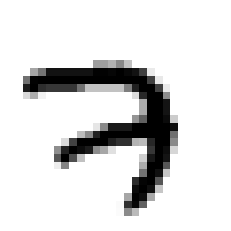

In [65]:
plt.imshow(X_train[0], cmap="binary", origin="upper")
plt.axis('off')
plt.show()

Note that we are doing 3-fold cross validation, so the validation set isn't being used for training, just for early stopping.

In [66]:
####Don't run this during class!  It will take too long!####
rnd_search_cv.fit(X_train, y_train, epochs=100, \
                  validation_data=(X_valid,y_valid),\
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/100
  21/1146 [..............................] - ETA: 5s - loss: 2.2988 - accuracy: 0.1131

2022-11-15 21:19:47.963742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.3967 - accuracy: 0.6671

2022-11-15 21:19:53.348600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.3967 - accuracy: 0.6671 - val_loss: 0.9403 - val_accuracy: 0.8138
Epoch 2/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.8106 - accuracy: 0.8281 - val_loss: 0.6945 - val_accuracy: 0.8496
Epoch 3/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.6551 - accuracy: 0.8501 - val_loss: 0.5930 - val_accuracy: 0.8652
Epoch 4/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5800 - accuracy: 0.8605 - val_loss: 0.5354 - val_accuracy: 0.8738
Epoch 5/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5342 - accuracy: 0.8675 - val_loss: 0.4980 - val_accuracy: 0.8788
Epoch 6/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5029 - accuracy: 0.8731 - val_loss: 0.4711 - val_accuracy: 0.8838
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.4798 - accuracy: 0.8773 - val_loss: 0.4508 - val_accuracy: 0.88

1146/1146 [==============================] - 5s 5ms/step - loss: 0.3143 - accuracy: 0.9123 - val_loss: 0.3019 - val_accuracy: 0.9186
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3135 - accuracy: 0.9122 - val_loss: 0.3012 - val_accuracy: 0.9188
Epoch 59/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3128 - accuracy: 0.9126 - val_loss: 0.3007 - val_accuracy: 0.9192
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3121 - accuracy: 0.9129 - val_loss: 0.3000 - val_accuracy: 0.9194
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3114 - accuracy: 0.9132 - val_loss: 0.2996 - val_accuracy: 0.9200
Epoch 62/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3107 - accuracy: 0.9134 - val_loss: 0.2989 - val_accuracy: 0.9194
Epoch 63/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3100 - accuracy: 0.9132 - val_loss: 0.2984 - val_accuracy

2022-11-15 21:28:48.600068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3142 - accuracy: 0.9123
[CV] END ............................n_hidden=0, n_neurons=5; total time= 9.1min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  24/1146 [..............................] - ETA: 5s - loss: 2.4476 - accuracy: 0.0742

2022-11-15 21:28:51.156980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.4497 - accuracy: 0.6399

2022-11-15 21:28:56.143366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.4497 - accuracy: 0.6399 - val_loss: 0.9596 - val_accuracy: 0.7946
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.8180 - accuracy: 0.8231 - val_loss: 0.7037 - val_accuracy: 0.8442
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6571 - accuracy: 0.8479 - val_loss: 0.5994 - val_accuracy: 0.8618
Epoch 4/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5802 - accuracy: 0.8601 - val_loss: 0.5407 - val_accuracy: 0.8682
Epoch 5/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5336 - accuracy: 0.8673 - val_loss: 0.5030 - val_accuracy: 0.8726
Epoch 6/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5017 - accuracy: 0.8731 - val_loss: 0.4750 - val_accuracy: 0.8778
Epoch 7/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4783 - accuracy: 0.8762 - val_loss: 0.4543 - val_accuracy: 0.88

1146/1146 [==============================] - 5s 5ms/step - loss: 0.3126 - accuracy: 0.9148 - val_loss: 0.3032 - val_accuracy: 0.9176
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3118 - accuracy: 0.9147 - val_loss: 0.3026 - val_accuracy: 0.9172
Epoch 59/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3111 - accuracy: 0.9148 - val_loss: 0.3020 - val_accuracy: 0.9178
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3104 - accuracy: 0.9149 - val_loss: 0.3012 - val_accuracy: 0.9182
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3096 - accuracy: 0.9150 - val_loss: 0.3008 - val_accuracy: 0.9178
Epoch 62/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3089 - accuracy: 0.9154 - val_loss: 0.3003 - val_accuracy: 0.9182
Epoch 63/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3083 - accuracy: 0.9155 - val_loss: 0.2998 - val_accuracy

2022-11-15 21:38:00.514396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3207 - accuracy: 0.9086
[CV] END ............................n_hidden=0, n_neurons=5; total time= 9.2min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  20/1146 [..............................] - ETA: 6s - loss: 2.3253 - accuracy: 0.0922

2022-11-15 21:38:03.289402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1143/1146 [============================>.] - ETA: 0s - loss: 1.4106 - accuracy: 0.6621

2022-11-15 21:38:08.696962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.4094 - accuracy: 0.6624 - val_loss: 0.9390 - val_accuracy: 0.8158
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.8158 - accuracy: 0.8301 - val_loss: 0.6913 - val_accuracy: 0.8532
Epoch 3/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.6596 - accuracy: 0.8500 - val_loss: 0.5895 - val_accuracy: 0.8666
Epoch 4/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5842 - accuracy: 0.8615 - val_loss: 0.5328 - val_accuracy: 0.8734
Epoch 5/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5383 - accuracy: 0.8677 - val_loss: 0.4955 - val_accuracy: 0.8772
Epoch 6/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5067 - accuracy: 0.8733 - val_loss: 0.4688 - val_accuracy: 0.8830
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.4836 - accuracy: 0.8769 - val_loss: 0.4487 - val_accuracy: 0.88

1146/1146 [==============================] - 6s 5ms/step - loss: 0.3179 - accuracy: 0.9107 - val_loss: 0.3029 - val_accuracy: 0.9192
Epoch 58/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3171 - accuracy: 0.9111 - val_loss: 0.3022 - val_accuracy: 0.9182
Epoch 59/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3164 - accuracy: 0.9117 - val_loss: 0.3016 - val_accuracy: 0.9194
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3157 - accuracy: 0.9116 - val_loss: 0.3009 - val_accuracy: 0.9194
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3150 - accuracy: 0.9119 - val_loss: 0.3006 - val_accuracy: 0.9194
Epoch 62/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3143 - accuracy: 0.9116 - val_loss: 0.3001 - val_accuracy: 0.9202
Epoch 63/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3136 - accuracy: 0.9121 - val_loss: 0.2996 - val_accuracy

2022-11-15 21:47:15.465549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3051 - accuracy: 0.9150
[CV] END ............................n_hidden=0, n_neurons=5; total time= 9.2min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  25/1146 [..............................] - ETA: 5s - loss: 2.4197 - accuracy: 0.1000 

2022-11-15 21:47:18.622395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1143/1146 [============================>.] - ETA: 0s - loss: 1.4409 - accuracy: 0.6510

2022-11-15 21:47:23.481500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.4398 - accuracy: 0.6514 - val_loss: 0.9554 - val_accuracy: 0.8060
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.8182 - accuracy: 0.8256 - val_loss: 0.7018 - val_accuracy: 0.8440
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6586 - accuracy: 0.8483 - val_loss: 0.5980 - val_accuracy: 0.8622
Epoch 4/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5821 - accuracy: 0.8607 - val_loss: 0.5394 - val_accuracy: 0.8712
Epoch 5/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5356 - accuracy: 0.8674 - val_loss: 0.5012 - val_accuracy: 0.8788
Epoch 6/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5040 - accuracy: 0.8725 - val_loss: 0.4737 - val_accuracy: 0.8824
Epoch 7/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4806 - accuracy: 0.8764 - val_loss: 0.4531 - val_accuracy: 0.88

1146/1146 [==============================] - 5s 5ms/step - loss: 0.3147 - accuracy: 0.9121 - val_loss: 0.3024 - val_accuracy: 0.9186
Epoch 58/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3139 - accuracy: 0.9122 - val_loss: 0.3017 - val_accuracy: 0.9188
Epoch 59/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3131 - accuracy: 0.9126 - val_loss: 0.3012 - val_accuracy: 0.9188
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3124 - accuracy: 0.9129 - val_loss: 0.3005 - val_accuracy: 0.9188
Epoch 61/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3117 - accuracy: 0.9124 - val_loss: 0.3001 - val_accuracy: 0.9178
Epoch 62/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3110 - accuracy: 0.9131 - val_loss: 0.2994 - val_accuracy: 0.9182
Epoch 63/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3103 - accuracy: 0.9133 - val_loss: 0.2989 - val_accuracy

2022-11-15 21:56:20.740987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3151 - accuracy: 0.9119
[CV] END ...........................n_hidden=0, n_neurons=10; total time= 9.1min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1143/1146 [============================>.] - ETA: 0s - loss: 1.3841 - accuracy: 0.6730

2022-11-15 21:56:23.392085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 21:56:28.513626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.3830 - accuracy: 0.6733 - val_loss: 0.9320 - val_accuracy: 0.8132
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.8021 - accuracy: 0.8298 - val_loss: 0.6881 - val_accuracy: 0.8528
Epoch 3/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.6469 - accuracy: 0.8517 - val_loss: 0.5874 - val_accuracy: 0.8666
Epoch 4/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5721 - accuracy: 0.8623 - val_loss: 0.5303 - val_accuracy: 0.8758
Epoch 5/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5267 - accuracy: 0.8693 - val_loss: 0.4938 - val_accuracy: 0.8820
Epoch 6/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4957 - accuracy: 0.8739 - val_loss: 0.4667 - val_accuracy: 0.8874
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.4728 - accuracy: 0.8783 - val_loss: 0.4467 - val_accuracy: 0.89

1146/1146 [==============================] - 6s 5ms/step - loss: 0.3110 - accuracy: 0.9156 - val_loss: 0.3010 - val_accuracy: 0.9180
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3102 - accuracy: 0.9156 - val_loss: 0.3004 - val_accuracy: 0.9176
Epoch 59/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3095 - accuracy: 0.9162 - val_loss: 0.2998 - val_accuracy: 0.9176
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3088 - accuracy: 0.9162 - val_loss: 0.2991 - val_accuracy: 0.9178
Epoch 61/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3081 - accuracy: 0.9163 - val_loss: 0.2987 - val_accuracy: 0.9174
Epoch 62/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3074 - accuracy: 0.9162 - val_loss: 0.2982 - val_accuracy: 0.9178
Epoch 63/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3067 - accuracy: 0.9161 - val_loss: 0.2978 - val_accuracy

2022-11-15 22:16:37.601863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3206 - accuracy: 0.9078
[CV] END ...........................n_hidden=0, n_neurons=10; total time=20.3min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  23/1146 [..............................] - ETA: 5s - loss: 2.3272 - accuracy: 0.1087

2022-11-15 22:16:40.334596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.4191 - accuracy: 0.6535

2022-11-15 22:16:45.473489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.4191 - accuracy: 0.6535 - val_loss: 0.9419 - val_accuracy: 0.8104
Epoch 2/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.8214 - accuracy: 0.8238 - val_loss: 0.6940 - val_accuracy: 0.8500
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6634 - accuracy: 0.8474 - val_loss: 0.5919 - val_accuracy: 0.8666
Epoch 4/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5870 - accuracy: 0.8589 - val_loss: 0.5347 - val_accuracy: 0.8736
Epoch 5/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5405 - accuracy: 0.8667 - val_loss: 0.4971 - val_accuracy: 0.8774
Epoch 6/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.5084 - accuracy: 0.8717 - val_loss: 0.4702 - val_accuracy: 0.8822
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.4849 - accuracy: 0.8759 - val_loss: 0.4499 - val_accuracy: 0.88

1146/1146 [==============================] - 6s 5ms/step - loss: 0.3179 - accuracy: 0.9108 - val_loss: 0.3030 - val_accuracy: 0.9198
Epoch 58/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3172 - accuracy: 0.9114 - val_loss: 0.3024 - val_accuracy: 0.9192
Epoch 59/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3164 - accuracy: 0.9118 - val_loss: 0.3017 - val_accuracy: 0.9192
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3157 - accuracy: 0.9118 - val_loss: 0.3010 - val_accuracy: 0.9198
Epoch 61/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3150 - accuracy: 0.9118 - val_loss: 0.3007 - val_accuracy: 0.9192
Epoch 62/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3143 - accuracy: 0.9120 - val_loss: 0.3001 - val_accuracy: 0.9196
Epoch 63/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.3137 - accuracy: 0.9120 - val_loss: 0.2997 - val_accuracy

2022-11-15 22:25:52.944195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3044 - accuracy: 0.9156
[CV] END ...........................n_hidden=0, n_neurons=10; total time= 9.3min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 22:25:55.636742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.9887 - accuracy: 0.3176

2022-11-15 22:26:01.531899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 7s 5ms/step - loss: 1.9887 - accuracy: 0.3176 - val_loss: 1.6971 - val_accuracy: 0.4564
Epoch 2/100
1146/1146 [==============================] - 6s 5ms/step - loss: 1.5217 - accuracy: 0.4975 - val_loss: 1.3435 - val_accuracy: 0.5642
Epoch 3/100
1146/1146 [==============================] - 6s 5ms/step - loss: 1.2569 - accuracy: 0.5920 - val_loss: 1.1406 - val_accuracy: 0.6498
Epoch 4/100
1146/1146 [==============================] - 6s 5ms/step - loss: 1.0988 - accuracy: 0.6592 - val_loss: 1.0114 - val_accuracy: 0.6942
Epoch 5/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.9897 - accuracy: 0.6999 - val_loss: 0.9189 - val_accuracy: 0.7304
Epoch 6/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.9096 - accuracy: 0.7292 - val_loss: 0.8472 - val_accuracy: 0.7528
Epoch 7/100
1146/1146 [==============================] - 6s 5ms/step - loss: 0.8322 - accuracy: 0.7536 - val_loss: 0.7714 - val_accuracy: 0.77

1146/1146 [==============================] - 5s 4ms/step - loss: 0.3857 - accuracy: 0.8897 - val_loss: 0.3784 - val_accuracy: 0.8930
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3843 - accuracy: 0.8898 - val_loss: 0.3766 - val_accuracy: 0.8958
Epoch 59/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3832 - accuracy: 0.8898 - val_loss: 0.3763 - val_accuracy: 0.8954
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3821 - accuracy: 0.8903 - val_loss: 0.3746 - val_accuracy: 0.8970
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3810 - accuracy: 0.8912 - val_loss: 0.3740 - val_accuracy: 0.8972
Epoch 62/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3798 - accuracy: 0.8915 - val_loss: 0.3721 - val_accuracy: 0.8974
Epoch 63/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.3790 - accuracy: 0.8916 - val_loss: 0.3721 - val_accuracy

2022-11-15 22:34:36.418091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.3887 - accuracy: 0.8925
[CV] END ............................n_hidden=1, n_neurons=5; total time= 8.7min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 22:34:38.897477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1143/1146 [============================>.] - ETA: 0s - loss: 2.0879 - accuracy: 0.2561

2022-11-15 22:34:43.714458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 5s 5ms/step - loss: 2.0869 - accuracy: 0.2567 - val_loss: 1.7831 - val_accuracy: 0.4392
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 1.5303 - accuracy: 0.5137 - val_loss: 1.3164 - val_accuracy: 0.5608
Epoch 3/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.1593 - accuracy: 0.6218 - val_loss: 1.0241 - val_accuracy: 0.6810
Epoch 4/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.9286 - accuracy: 0.7138 - val_loss: 0.8458 - val_accuracy: 0.7484
Epoch 5/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.7859 - accuracy: 0.7643 - val_loss: 0.7371 - val_accuracy: 0.7796
Epoch 6/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.6973 - accuracy: 0.7910 - val_loss: 0.6654 - val_accuracy: 0.8076
Epoch 7/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6391 - accuracy: 0.8098 - val_loss: 0.6184 - val_accuracy: 0.82

1146/1146 [==============================] - 5s 4ms/step - loss: 0.3781 - accuracy: 0.8912 - val_loss: 0.3797 - val_accuracy: 0.8916
Epoch 58/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3772 - accuracy: 0.8916 - val_loss: 0.3791 - val_accuracy: 0.8938
Epoch 59/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3765 - accuracy: 0.8921 - val_loss: 0.3779 - val_accuracy: 0.8926
Epoch 60/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3754 - accuracy: 0.8923 - val_loss: 0.3783 - val_accuracy: 0.8950
Epoch 61/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3747 - accuracy: 0.8922 - val_loss: 0.3775 - val_accuracy: 0.8938
Epoch 62/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3742 - accuracy: 0.8922 - val_loss: 0.3754 - val_accuracy: 0.8940
Epoch 63/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.3733 - accuracy: 0.8932 - val_loss: 0.3762 - val_accuracy

2022-11-15 22:43:08.728222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.4020 - accuracy: 0.8882
[CV] END ............................n_hidden=1, n_neurons=5; total time= 8.5min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 22:43:11.173744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1145/1146 [============================>.] - ETA: 0s - loss: 2.0624 - accuracy: 0.2898

2022-11-15 22:43:15.974417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 5s 5ms/step - loss: 2.0622 - accuracy: 0.2901 - val_loss: 1.8253 - val_accuracy: 0.4056
Epoch 2/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.6524 - accuracy: 0.4926 - val_loss: 1.4559 - val_accuracy: 0.5478
Epoch 3/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.3223 - accuracy: 0.6053 - val_loss: 1.1328 - val_accuracy: 0.6768
Epoch 4/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.0400 - accuracy: 0.6876 - val_loss: 0.9023 - val_accuracy: 0.7348
Epoch 5/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.8763 - accuracy: 0.7391 - val_loss: 0.7831 - val_accuracy: 0.7760
Epoch 6/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.7826 - accuracy: 0.7656 - val_loss: 0.7086 - val_accuracy: 0.7934
Epoch 7/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.7213 - accuracy: 0.7826 - val_loss: 0.6604 - val_accuracy: 0.80

1146/1146 [==============================] - 5s 4ms/step - loss: 0.4383 - accuracy: 0.8707 - val_loss: 0.4330 - val_accuracy: 0.8764
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4369 - accuracy: 0.8718 - val_loss: 0.4320 - val_accuracy: 0.8770
Epoch 59/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4355 - accuracy: 0.8720 - val_loss: 0.4293 - val_accuracy: 0.8764
Epoch 60/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4337 - accuracy: 0.8726 - val_loss: 0.4278 - val_accuracy: 0.8748
Epoch 61/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4324 - accuracy: 0.8737 - val_loss: 0.4280 - val_accuracy: 0.8760
Epoch 62/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4310 - accuracy: 0.8740 - val_loss: 0.4266 - val_accuracy: 0.8776
Epoch 63/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4298 - accuracy: 0.8742 - val_loss: 0.4280 - val_accuracy

2022-11-15 22:51:39.843932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.4024 - accuracy: 0.8844
[CV] END ............................n_hidden=1, n_neurons=5; total time= 8.5min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 22:51:42.314417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.7879 - accuracy: 0.4302

2022-11-15 22:51:47.262167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.7879 - accuracy: 0.4302 - val_loss: 1.2952 - val_accuracy: 0.6526
Epoch 2/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.0191 - accuracy: 0.7389 - val_loss: 0.8074 - val_accuracy: 0.7950
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.7059 - accuracy: 0.8172 - val_loss: 0.6175 - val_accuracy: 0.8398
Epoch 4/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5737 - accuracy: 0.8467 - val_loss: 0.5253 - val_accuracy: 0.8640
Epoch 5/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.5046 - accuracy: 0.8631 - val_loss: 0.4719 - val_accuracy: 0.8776
Epoch 6/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4617 - accuracy: 0.8733 - val_loss: 0.4349 - val_accuracy: 0.8836
Epoch 7/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4324 - accuracy: 0.8811 - val_loss: 0.4099 - val_accuracy: 0.89

1146/1146 [==============================] - 5s 5ms/step - loss: 0.2531 - accuracy: 0.9287 - val_loss: 0.2547 - val_accuracy: 0.9274
Epoch 58/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2521 - accuracy: 0.9284 - val_loss: 0.2537 - val_accuracy: 0.9300
Epoch 59/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2515 - accuracy: 0.9296 - val_loss: 0.2541 - val_accuracy: 0.9272
Epoch 60/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2508 - accuracy: 0.9286 - val_loss: 0.2526 - val_accuracy: 0.9292
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2501 - accuracy: 0.9286 - val_loss: 0.2521 - val_accuracy: 0.9288
Epoch 62/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2493 - accuracy: 0.9295 - val_loss: 0.2515 - val_accuracy: 0.9296
Epoch 63/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2487 - accuracy: 0.9301 - val_loss: 0.2516 - val_accuracy

2022-11-15 23:00:15.545786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 3s 4ms/step - loss: 0.2675 - accuracy: 0.9241
[CV] END ...........................n_hidden=1, n_neurons=10; total time= 8.6min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 23:00:18.038107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.8457 - accuracy: 0.4015

2022-11-15 23:00:22.930948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.8457 - accuracy: 0.4015 - val_loss: 1.4604 - val_accuracy: 0.5822
Epoch 2/100
1146/1146 [==============================] - 5s 4ms/step - loss: 1.1732 - accuracy: 0.6857 - val_loss: 0.9201 - val_accuracy: 0.7592
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.7915 - accuracy: 0.8030 - val_loss: 0.6734 - val_accuracy: 0.8354
Epoch 4/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.6182 - accuracy: 0.8419 - val_loss: 0.5529 - val_accuracy: 0.8582
Epoch 5/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5263 - accuracy: 0.8610 - val_loss: 0.4848 - val_accuracy: 0.8700
Epoch 6/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4711 - accuracy: 0.8727 - val_loss: 0.4401 - val_accuracy: 0.8816
Epoch 7/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4352 - accuracy: 0.8808 - val_loss: 0.4110 - val_accuracy: 0.88

1146/1146 [==============================] - 5s 4ms/step - loss: 0.2492 - accuracy: 0.9311 - val_loss: 0.2516 - val_accuracy: 0.9306
Epoch 58/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2483 - accuracy: 0.9312 - val_loss: 0.2510 - val_accuracy: 0.9312
Epoch 59/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2476 - accuracy: 0.9314 - val_loss: 0.2504 - val_accuracy: 0.9306
Epoch 60/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2467 - accuracy: 0.9313 - val_loss: 0.2498 - val_accuracy: 0.9308
Epoch 61/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2459 - accuracy: 0.9321 - val_loss: 0.2491 - val_accuracy: 0.9312
Epoch 62/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2453 - accuracy: 0.9322 - val_loss: 0.2488 - val_accuracy: 0.9314
Epoch 63/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2445 - accuracy: 0.9322 - val_loss: 0.2493 - val_accuracy

2022-11-15 23:08:53.447373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.2699 - accuracy: 0.9245
[CV] END ...........................n_hidden=1, n_neurons=10; total time= 8.6min
Epoch 1/100


/Users/gtr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-11-15 23:08:55.908072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - ETA: 0s - loss: 1.7673 - accuracy: 0.4267

2022-11-15 23:09:00.696954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1146/1146 [==============================] - 6s 5ms/step - loss: 1.7673 - accuracy: 0.4267 - val_loss: 1.2487 - val_accuracy: 0.7006
Epoch 2/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.9842 - accuracy: 0.7676 - val_loss: 0.7615 - val_accuracy: 0.8218
Epoch 3/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.6851 - accuracy: 0.8277 - val_loss: 0.5841 - val_accuracy: 0.8522
Epoch 4/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.5627 - accuracy: 0.8529 - val_loss: 0.5008 - val_accuracy: 0.8702
Epoch 5/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4977 - accuracy: 0.8669 - val_loss: 0.4490 - val_accuracy: 0.8822
Epoch 6/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.4563 - accuracy: 0.8757 - val_loss: 0.4148 - val_accuracy: 0.8898
Epoch 7/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.4281 - accuracy: 0.8819 - val_loss: 0.3906 - val_accuracy: 0.89

1146/1146 [==============================] - 5s 5ms/step - loss: 0.2556 - accuracy: 0.9273 - val_loss: 0.2487 - val_accuracy: 0.9318
Epoch 58/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2546 - accuracy: 0.9275 - val_loss: 0.2476 - val_accuracy: 0.9320
Epoch 59/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2538 - accuracy: 0.9274 - val_loss: 0.2466 - val_accuracy: 0.9316
Epoch 60/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2525 - accuracy: 0.9281 - val_loss: 0.2462 - val_accuracy: 0.9326
Epoch 61/100
1146/1146 [==============================] - 5s 5ms/step - loss: 0.2515 - accuracy: 0.9281 - val_loss: 0.2459 - val_accuracy: 0.9318
Epoch 62/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2504 - accuracy: 0.9288 - val_loss: 0.2457 - val_accuracy: 0.9330
Epoch 63/100
1146/1146 [==============================] - 5s 4ms/step - loss: 0.2497 - accuracy: 0.9286 - val_loss: 0.2458 - val_accuracy

2022-11-15 23:17:30.857324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


573/573 [==============================] - 2s 4ms/step - loss: 0.2441 - accuracy: 0.9312
[CV] END ...........................n_hidden=1, n_neurons=10; total time= 8.6min
Epoch 1/100
  23/1719 [..............................] - ETA: 7s - loss: 2.3947 - accuracy: 0.1236

2022-11-15 23:17:33.337684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1714/1719 [============================>.] - ETA: 0s - loss: 1.6147 - accuracy: 0.5121

2022-11-15 23:17:40.431462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 8s 4ms/step - loss: 1.6129 - accuracy: 0.5129 - val_loss: 1.0416 - val_accuracy: 0.7604
Epoch 2/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8009 - accuracy: 0.7983 - val_loss: 0.6408 - val_accuracy: 0.8332
Epoch 3/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5750 - accuracy: 0.8441 - val_loss: 0.5124 - val_accuracy: 0.8630
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4885 - accuracy: 0.8645 - val_loss: 0.4525 - val_accuracy: 0.8788
Epoch 5/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4441 - accuracy: 0.8761 - val_loss: 0.4179 - val_accuracy: 0.8846
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4164 - accuracy: 0.8833 - val_loss: 0.3955 - val_accuracy: 0.8908
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3971 - accuracy: 0.8879 - val_loss: 0.3780 - val_accuracy: 0.89

1719/1719 [==============================] - 7s 4ms/step - loss: 0.2557 - accuracy: 0.9287 - val_loss: 0.2502 - val_accuracy: 0.9270
Epoch 58/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2549 - accuracy: 0.9293 - val_loss: 0.2500 - val_accuracy: 0.9276
Epoch 59/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2542 - accuracy: 0.9292 - val_loss: 0.2487 - val_accuracy: 0.9276
Epoch 60/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2533 - accuracy: 0.9299 - val_loss: 0.2485 - val_accuracy: 0.9292
Epoch 61/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2526 - accuracy: 0.9298 - val_loss: 0.2477 - val_accuracy: 0.9304
Epoch 62/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2519 - accuracy: 0.9305 - val_loss: 0.2471 - val_accuracy: 0.9292
Epoch 63/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2512 - accuracy: 0.9304 - val_loss: 0.2462 - val_accuracy

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x29d34bfa0>,
                   param_distributions={'n_hidden': (0, 1),
                                        'n_neurons': (5, 10)},
                   verbose=2)

In [67]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.cv_results_)

{'n_neurons': 10, 'n_hidden': 1}
{'mean_fit_time': array([547.57224758, 770.02661212, 513.27455966, 514.49816537]), 'std_fit_time': array([  4.90471475, 314.21246396,   5.4850142 ,   1.19513836]), 'mean_score_time': array([2.43421292, 2.52190932, 2.30200434, 2.49883596]), 'std_score_time': array([0.11930972, 0.0162952 , 0.01264741, 0.25625567]), 'param_n_neurons': masked_array(data=[5, 10, 5, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_hidden': masked_array(data=[0, 0, 1, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neurons': 5, 'n_hidden': 0}, {'n_neurons': 10, 'n_hidden': 0}, {'n_neurons': 5, 'n_hidden': 1}, {'n_neurons': 10, 'n_hidden': 1}], 'split0_test_score': array([0.91229409, 0.91191226, 0.89254934, 0.92413002]), 'split1_test_score': array([0.90858018, 0.90781653, 0.88823432, 0.9244532 ]), 'split2_test_score': array([0.91501665, 0.91561663,

In [68]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

---

### Advanced Topics in Neural Networks with Deep Learning

Recent interest in neural networks surged in 2012 when a team using a deep [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) acheived record results classifying objects in the [ImageNet](http://image-net.org/) data set.

The idea behind CNNs is inspired by human visual perception.  Each neuron in your visual cortex doesn't "see" all of what your eye can see at once and some neuron are more sensitive to one pattern over another (e.g., horizontal lines vs. vertical lines).  

Moreover, the simplest deeply connected neural networks would choke on "real" data which has far more than 28x28 pixels and would require following tens of millions of connections.  So we use a combination of "convolution" and "pooling" to reduce the dimensionality of the data first.

![Ivezic Figure 9.19](https://www.astroml.org/_images/fig_cnn_1.png)

### Convolutional Layers

In a convolutional layer, each neuron is not connected to each neuron in the previous layer, but only those that are within its "field of view" as defined by a kernel (filter).  We slide the kernel over the input layer and the value in the next layer depends only on those pixels.

![Convolutional Layer](https://miro.medium.com/max/1400/1*wLlXFtWI--7knyQT2wlhMg.png)

Here's another perspective that helps to visualize going from one layer to the next.

![Convolution example](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg)

[Geron14-3.png](attachment:Geron14-3.png)

[Geron14-4.png](attachment:Geron14-4.png)

Choosing a filter (kernel) with a certain pattern can help recognize certain types of features (like horizontal aor vertical lines).

![vertical filter](https://miro.medium.com/max/1338/1*7IEbBib7Yc7qST5IGQoYXA.jpeg)

![horizontal filter](https://miro.medium.com/max/1238/1*PSSAaH2pZbl5bK3Ef_zk4A.jpeg)

[Geron14-5.png](attachment:Geron14-5.png)

It is common to follow the convolutional layer by a so-called "pooling layer", essentially to reduce the amount of data that needs to be processed.  The full architecture of a CNN might look something like this:
![CNN Example](https://www.researchgate.net/profile/Xian_Wei2/publication/331986652/figure/fig1/AS:740547106988032@1553571597647/The-classic-structure-of-CNN-It-consists-of-two-modules-Feature-extraction-module-and.ppm)

Where the pooling layers are reducing the number of pixels by averaging, summing, taking the max, etc.:

![Pooling example](https://miro.medium.com/max/1000/1*ydNsGDxMldAiq7b96GDQwg.jpeg)

[Geron14-8.png](attachment:Geron14-8.png)

[Geron14-9.png](attachment:Geron14-9.png)

[Geron14-11.png](attachment:Geron14-11.png)

When you are done, the output gets feed into a regular, fully connected neural network which outputs the predictions.

This is clearly much more sophisticated than our basic perceptron. "Deep" networks consist of tens of layers with thousands of neurons. These large networks have become usable thanks to two breakthroughs: the use of sparse layers and the power of graphics processing units (GPUs).

The sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.

Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration.

For further study, there are lots of resources for CNNs online.  For example, see
https://medium.com/analytics-vidhya/convolutional-neural-networks-cnn-explained-step-by-step-69137a54e5e7
    
Now let's see a worked example of a CNN.

GTR: Output of convolution is a "feature map".  Number of weights needed (which are computed from backpropagation is just the kernel size times the number of layers.)

### CNN Example using Fashion MNIST

See https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

In [ ]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [ ]:
#Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [ ]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

"same" is with zero padding.

In [ ]:
model.summary()

Now let's see how well this model does.

In [ ]:
score = model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10] # to represent "new" images
print(X_new.shape)

y_pred = model.predict(X_new)
print(y_pred)

Use the `history` output to see the improvement in performance with each epoch.

In [ ]:
import matplotlib.pyplot as plt
  
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
  
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss') 
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()


---

With image data one of the cool things that we can do is to visualize what the kernel in a given convolutional layer is actually doing.

[GTR: However, I can't remember where I got this from and I can't get the last cell to work because I don't have the code for the "convolution" function.]

In [ ]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
len(weights1)

In [ ]:
kernels1 = weights1[0]
kernels1.shape

kernels1_1 = kernels1[:,:,0,0]
kernels1_1.shape

In [ ]:
plt.imshow(kernels1_1)

In [ ]:
test_image = X_test[0, :, :, 0]
plt.imshow(test_image, origin='upper')

---

---

### Autoencoders

Autoencoders are neural networks that copy their input to their output, but after passing the data through a bottleneck.  For example if there are 28x28 = 784 inputs, there will also be 784 outputs, but there will be one or more (odd, but symmetric) hidden layers with fewer neuron than that.

For example see 

![autoencoder structure](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

from
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

So, distill our MNIST digits down to the three most important pixels.  Or perhaps the three most important line segments.

You can think of this as doing PCA with a neural network -- breaking our data down into the only the most important features that we actually *need* (finding the intrinsic dimensionality).   In fact, if the network uses only linear (or no) activation functions and $l2$ cost function, then we have exactly PCA.

How might this be useful?  Well, for example we can use it to reconstruct MNIST digits that have had noise added to them:

![autoencoder example](https://miro.medium.com/max/1400/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

### Autoencoder Example

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders) and run it on the fashion MNIST data set.

See
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

Specifically, we are going to build this:

[Geron17-3autoencoder.png](attachment:Geron17-3autoencoder.png)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Let's look at the output reconstructions.

In [ ]:
#Helper function from Geron to show example reconstructions
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary", origin='upper')
        plt.axis("off")  
        
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary", origin='upper')
        plt.axis("off")                 

In [ ]:
show_reconstructions(stacked_ae)

Now we can use t-SNE to visualize the clustering

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

---

#### Variational Autoencoders

More common in astronomy are variational autoencoders, partly because the "latent space" that results from a standard autoencoder doesn't necessarily map continuously to the data (e.g., if your training data don't span the full data space).  We won't go into detail, just realize that these are something that you might try if you were otherwise going to try an autoencoder to tackle your problem.

![Ivezic Figure 9.21](https://www.astroml.org/_images/fig_vae_1.png)

[Geron17-12variational_autoencoder.png](attachment:Geron17-12variational_autoencoder.png)

#### Variational Autoencoder Example

Until GANs (see below), this is how you would have generated fake images.

In [ ]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
history = variational_ae.fit(X_train, X_train, epochs=20, batch_size=128,
                             validation_data=(X_valid, X_valid))

Now generate some fake images.  Note that the goal here is NOT to teach you how to create "deep fakes", but rather to build up to scientifically useful applications of GANs.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary", origin='upper')
        plt.axis("off")

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

---

### Generative Adversarial Networks (GANs)

GANs are pure evil, see
https://thispersondoesnotexist.com

But they are also brilliant, incredibly useful, and relatively new (2014).  The idea builds logically on autoencoders in that we have a generator (like the decoder part of an autoencoder) that can produce fake data (e.g., an image).  Then we have a discriminator (a standard binary classifier) that tries to distinguish fake data from real.  Then the generator learns to produce more and more accurate images to trick the discriminator -- without ever seeing any real images -- it just has the feedback from the discriminator.

[Geron17-15GAN.png](attachment:Geron17-15GAN.png)

[Geron17-18GANexample.png](attachment:Geron17-18GANexample.png)

For more, see
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

Astronomy has seen some interesting uses of autoencoders and GANs in recent years.  For example:
    
https://arxiv.org/abs/1702.00403    
https://www.aanda.org/articles/aa/full_html/2017/07/aa30240-16/aa30240-16.html

### Generative Adversarial Network (GAN) example

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()         

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Geron then runs the GAN for 50 epochs and discusses why training GANs is so hard and is still an active area of research.

---

---

More exciting to me is the possibility to use autoencoders for "unsupervised pretraining".  For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have.  See Geron Figure 17.6

Also for [anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html).
See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

The last example will pretend that we have a very large training set, but with only a small fraction of the training set having labels.  So, we will use tranfer learning from a pre-trained autoencoder that "clusters" all of the unlabeled training data to build the base layers of a our classification neural network.

[Geron17-6transferlearning.png](attachment:Geron17-6transferlearning.png)

[Geron](./figures/Geron17-6transferlearning.png)

This is exactly the problem that we have for quasar selection in LSST.  We have about 500k quasars that are labeled (plus labels for stars and galaxies) but those objects don't necessarily represent the full range of objects that we are trying to find.  So, it might help to use this pre-training technique.

We'll do this with Fashion MNIST data set as above.  Let's train the autoencoder with 2/3 of the full training set data (but without the labels!), which is 40k objects.  Then we'll have 10k for the test set, the validation set, and our "B" training set.  Then we'll see how that compares to a regular neural net trained with only the "B" training data.

See 
https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
and
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [ ]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [ ]:
#We'll use 60% of the sample to do unsupervised training with an autoencoder
#Then 10% each for supervised training, validation, and testing
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
print(len(X_train_full),len(X_test))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_A, X_rest, y_train_A, y_rest = train_test_split(X_train_full, y_train_full, test_size=0.33333, random_state=42)
print(len(X_train_A),len(X_rest))

X_train_B, X_valid, y_train_B, y_valid = train_test_split(X_rest, y_rest, test_size=0.50, random_state=42)
print(len(X_train_B),len(X_valid))

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(200, activation="selu", input_shape=[100]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train_A, X_train_A, epochs=50,
                         validation_data=(X_valid, X_valid))

In [ ]:
stacked_encoder.summary()

In [ ]:
stacked_decoder.summary()

In [ ]:
stacked_ae.summary()

In [ ]:
stacked_ae.save("autoencoder.h5")

In [ ]:
from sklearn.manifold import TSNE

#Maybe should be X_train_A if want to visualize clustering of autoencoder training results?
#But plot validation objects on top?
#X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_compressed = stacked_encoder.predict(X_train_A)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
#plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_train_A, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            #mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            mpl.offsetbox.OffsetImage(X_train_A[index], cmap="binary", origin='upper'),
            #position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
            position, bboxprops={"edgecolor": cmap(y_train_A[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
model_A = keras.models.load_model("autoencoder.h5") #Read in full autoencoder model
#model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) #Just take the encoder part
#model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

In [ ]:
#Need to clone model A and set weights otherwise they will be update when fitting model_B_on_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) #Just take the encoder part
model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

#Freeze reused layers during first few epochs
#Later will have to unfreeze
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [ ]:
#Now need to compile
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
#Run for a few epochs
#Here we need the answers; don't use data that trained autoencoder.
#Might not be OK to use test data for validation here?
history2 = model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                    validation_data=(X_valid, y_valid))

In [ ]:
#Unfreeze reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [ ]:
#Recompile with lower learning rate
#Keep fitting for more epochs
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=40,
                           validation_data=(X_valid, y_valid))

In [ ]:
model_B_on_A.save("autoencoder_transfer_example.h5")

In [ ]:
model_B_on_A.evaluate(X_test, y_test)

In [ ]:
model_B = keras.models.Sequential() #Instantiate a sequential model
model_B.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model_B.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model_B.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model_B.add(keras.layers.Dense(10, activation="softmax")) #Output layer

In [ ]:
#Now need to compile
model_B.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history_B = model_B.fit(X_train_B, y_train_B, epochs=50,
                           validation_data=(X_valid, y_valid))

In [ ]:
model_B.evaluate(X_test, y_test)

We find that Model B is actually better than Model A on B.  Geron says that this shouldn't be expected to work well with a small dense network.  Need a deeper network (maybe even CNN) to get best reslts.  But this at least shows how it is done.

It is worth noting that we **do** have the answers for the full training set here, but if you did **NOT** then the 84.8% that we got (compared to 85.1%) is pretty darn good!

---

* Sigmoid needed for output of binary classification (with binary cross entropy loss)
* ReLU for layers other than output
* Softmax for output with more than 2 classes (with categorical cross entropy loss)

multi-label is like doing several binary classifications at once, so use sigmoid activation function.

One vs. rest

Train faster with mini-batches.  Updates weights N mini-batches times per epoch.
Batches normalize between layers.

Current version leaves no place for AdaBoost or LogisticRegression.